In [113]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pickle
import matplotlib.animation as animation

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 14,  # Increased base font size
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',  # Make all fonts bold by default
    'axes.linewidth': 2.0,  # Thicker axes lines
    'axes.labelsize': 16,  # Larger axis labels
    'axes.titlesize': 18,  # Larger titles
    'axes.labelweight': 'bold',  # Bold axis labels
    'axes.titleweight': 'bold',  # Bold titles
    'xtick.labelsize': 14,  # Larger tick labels
    'ytick.labelsize': 14,
    'xtick.major.width': 1.5,  # Thicker ticks
    'ytick.major.width': 1.5,
    'legend.fontsize': 12,  # Larger legend text
    'legend.title_fontsize': 14,
    'lines.linewidth': 3.0,  # Thicker plot lines
    'lines.markersize': 10,  # Larger markers
    'grid.linewidth': 1.0,  # Thicker grid lines
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2
})


In [114]:
def plot_spatial_profiles(results, method='rl', domain_length=0.008, n_timesteps=6):
    """
    Plot spatial profiles comparing selected method with CVODE at different timesteps
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results
    method : str
        Integration method to compare with CVODE ('rl', 'qss', 'heuristic')
    domain_length : float
        Physical domain length in meters
    n_timesteps : int
        Number of timesteps to plot (equally spaced)
    """
    
    # Check if selected method exists
    if method not in results or results[method] is None:
        print(f"Results for method '{method}' not found")
        return
    
    # Check if CVODE exists for comparison
    if 'cvode' not in results or results['cvode'] is None:
        print("CVODE results not found for comparison")
        return
    
    # Extract data for both methods
    X_history_method = results[method]['X_history']
    T_history_method = results[method]['T_history']
    Y_history_method = results[method]['Y_history']
    X_history_cvode = results['cvode']['X_history']
    T_history_cvode = results['cvode']['T_history']
    Y_history_cvode = results['cvode']['Y_history']
    
    # Get dimensions
    n_time = len(T_history_method)
    n_grid = len(T_history_method[0]) # Use first timestep's grid size
    
    # Create spatial coordinate
    
    
    # Select timesteps (equally spaced)
    time_indices = np.linspace(0, n_time-1, n_timesteps, dtype=int)
    
    # Load mechanism to get species names
    gas = ct.Solution('large_mechanism/n-dodecane.yaml')
    
    # Species to plot
    species_to_plot = ['OH', 'HO2', 'CO2', 'CH2O', 'CO']
    species_indices = []
    for spec in species_to_plot:
        try:
            species_indices.append(gas.species_index(spec))
        except ValueError:
            print(f"Warning: Species {spec} not found in mechanism")
            species_indices.append(None)
    
    # Create distinct colors for different timesteps using a vibrant colormap
    colors = plt.cm.viridis(np.linspace(0, 1, n_timesteps))
    
    # Create subplots with increased spacing
    fig, axs = plt.subplots(3, 2, figsize=(18, 20))
    fig.suptitle(f'Spatial Profiles Comparison: {method.upper()} vs CVODE', 
                 fontsize=22, fontweight='bold', y=0.98)
    
    # Define subplot titles and positions
    subplot_data = [
        ('Temperature', 'T [K]', None, T_history_method, T_history_cvode),
        ('OH', f'Y_{{OH}} [-]', 0, None, None),
        ('HO2', f'Y_{{HO2}} [-]', 1, None, None),
        ('CO2', f'Y_{{CO2}} [-]', 2, None, None),
        ('CH2O', f'Y_{{CH2O}} [-]', 3, None, None),
        ('CO', f'Y_{{CO}} [-]', 4, None, None)
    ]
    
    # Plot each subplot
    for plot_idx, (title, ylabel, species_idx, T_method, T_cvode) in enumerate(subplot_data):
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axs[row, col]
        
        # Plot all timesteps
        for i, time_idx in enumerate(time_indices):
            
            if title == 'Temperature':
                X_method = np.array(X_history_method[time_idx])
                X_cvode = np.array(X_history_cvode[time_idx])
                profile_method = np.array(T_method[time_idx])
                profile_cvode = np.array(T_cvode[time_idx])
                
            else:
                if species_indices[species_idx] is None:
                    continue
                X_method = np.array(X_history_method[time_idx])
                X_cvode = np.array(X_history_cvode[time_idx])
                profile_method = np.array(Y_history_method[time_idx])[species_indices[species_idx], :]
                profile_cvode = np.array(Y_history_cvode[time_idx])[species_indices[species_idx], :]
               
                
            n_grid = len(profile_method)
            z = np.linspace(0, domain_length, n_grid)
            # Plot selected method with thicker lines
            ax.plot(X_method, profile_method, 
                   color=colors[i], 
                   linewidth=3.5,  # Thicker lines
                   linestyle='-', 
                   label=f'{method.upper()} t={time_idx}',
                   alpha=1.0)  # Full opacity
            
            # Plot CVODE with distinct style
            ax.plot(X_cvode, profile_cvode, 
                   color='black', 
                   linewidth=2.5, 
                   linestyle='--',  # Changed to dashed for better visibility
                   alpha=0.8)
        
        # Customize each subplot with enhanced visibility
        ax.set_xlabel('Z [mm]', fontweight='bold', fontsize=16)
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=16)
        ax.set_title(title, fontweight='bold', fontsize=18)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0)
        
        # Make spines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(2.0)
        
        # Enhance tick parameters
        ax.tick_params(width=2.0, length=6, labelsize=14)
        
        # Set log scale for species with small values
        if title != 'Temperature':
            max_val_method = max(np.max(np.array(y)[:, species_indices[species_idx]]) for y in Y_history_method)
            max_val_cvode = max(np.max(np.array(y)[:, species_indices[species_idx]]) for y in Y_history_cvode)
            if max(max_val_method, max_val_cvode) < 1e-2:
                ax.set_yscale('log')
                ax.set_ylim(bottom=1e-8)
    
    # Create enhanced legend
    legend_elements = []
    
    # Add timestep legends
    for i, time_idx in enumerate(time_indices):
        legend_elements.append(
            Line2D([0], [0], color=colors[i], linewidth=3.5, linestyle='-', 
                   label=f't = {time_idx}')
        )
    
    # Add method distinction
    legend_elements.extend([
        Line2D([0], [0], color='black', linewidth=3.5, linestyle='-', 
               label=f'{method.upper()} (solid)'),
        Line2D([0], [0], color='black', linewidth=2.5, linestyle='--', 
               label='CVODE (dashed)', alpha=0.8)
    ])
    
    # Place enhanced legend
    fig.legend(handles=legend_elements, 
              bbox_to_anchor=(1.04, 0.5), 
              loc='center left',
              frameon=True, 
              fancybox=True, 
              shadow=True,
              fontsize=14,
              title='Legend',
              title_fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, right=0.85, hspace=0.4, wspace=0.3)
    
    # Save high-quality plots
    plt.savefig(f'spatial_profiles_{method}_vs_cvode.pdf', format='pdf', 
                bbox_inches='tight', dpi=300)
    plt.savefig(f'spatial_profiles_{method}_vs_cvode.png', format='png', 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    return fig, axs

In [115]:
with open('new_data/results_1D_363_900_6079500__0__0.01__3000_rl_100.pkl', 'rb') as f:
    rl_data = pickle.load(f)

In [116]:
cvode_data = pickle.load(open('new_data/results_1D_363_900_6079500__0__0.01__3000_cvode_100.pkl', 'rb'))

In [117]:

qss_data = pickle.load(open('new_data/results_1D_363_900_6079500__0__0.01__3000_qss_100.pkl', 'rb'))


In [118]:


results = {
    'cvode': cvode_data,
    'qss': qss_data,
    'rl': rl_data
}




In [119]:
results['rl'].keys()

dict_keys(['T_final', 'T_initial', 'cpu_times', 'integrator_history', 'T_history', 'Y_history', 'X_history', 'total_cpu_time', 'mean_cpu_time', 'max_temperature'])

In [124]:
# Extract data for both methods

X_history_qss = results['qss']['X_history']
T_history_qss = results['qss']['T_history']
Y_history_qss = results['qss']['Y_history']
X_history_rl = results['rl']['X_history']
T_history_rl = results['rl']['T_history']
Y_history_rl = results['rl']['Y_history']
rl_action_selection = results['rl']['integrator_history']
X_history_cvode = results['cvode']['X_history']
T_history_cvode = results['cvode']['T_history']
Y_history_cvode = results['cvode']['Y_history']

# Get dimensions
n_time = len(T_history_qss)
n_grid = len(T_history_qss[0]) # Use first timestep's grid size

n_timesteps = 4
# Select timesteps (equally spaced)
time_indices = np.linspace(0, n_time-1, n_timesteps, dtype=int)

# Load mechanism to get species names
gas = ct.Solution('large_mechanism/n-dodecane.yaml')

# Species to plot
species_to_plot = ['OH', 'HO2', 'CO2', 'CH2O', 'CO']
species_indices = []
for spec in species_to_plot:
    try:
        species_indices.append(gas.species_index(spec))
    except ValueError:
        print(f"Warning: Species {spec} not found in mechanism")
        species_indices.append(None)


In [135]:
time_indices

array([   0,  333,  666, 1000])

In [136]:
n_time

1001

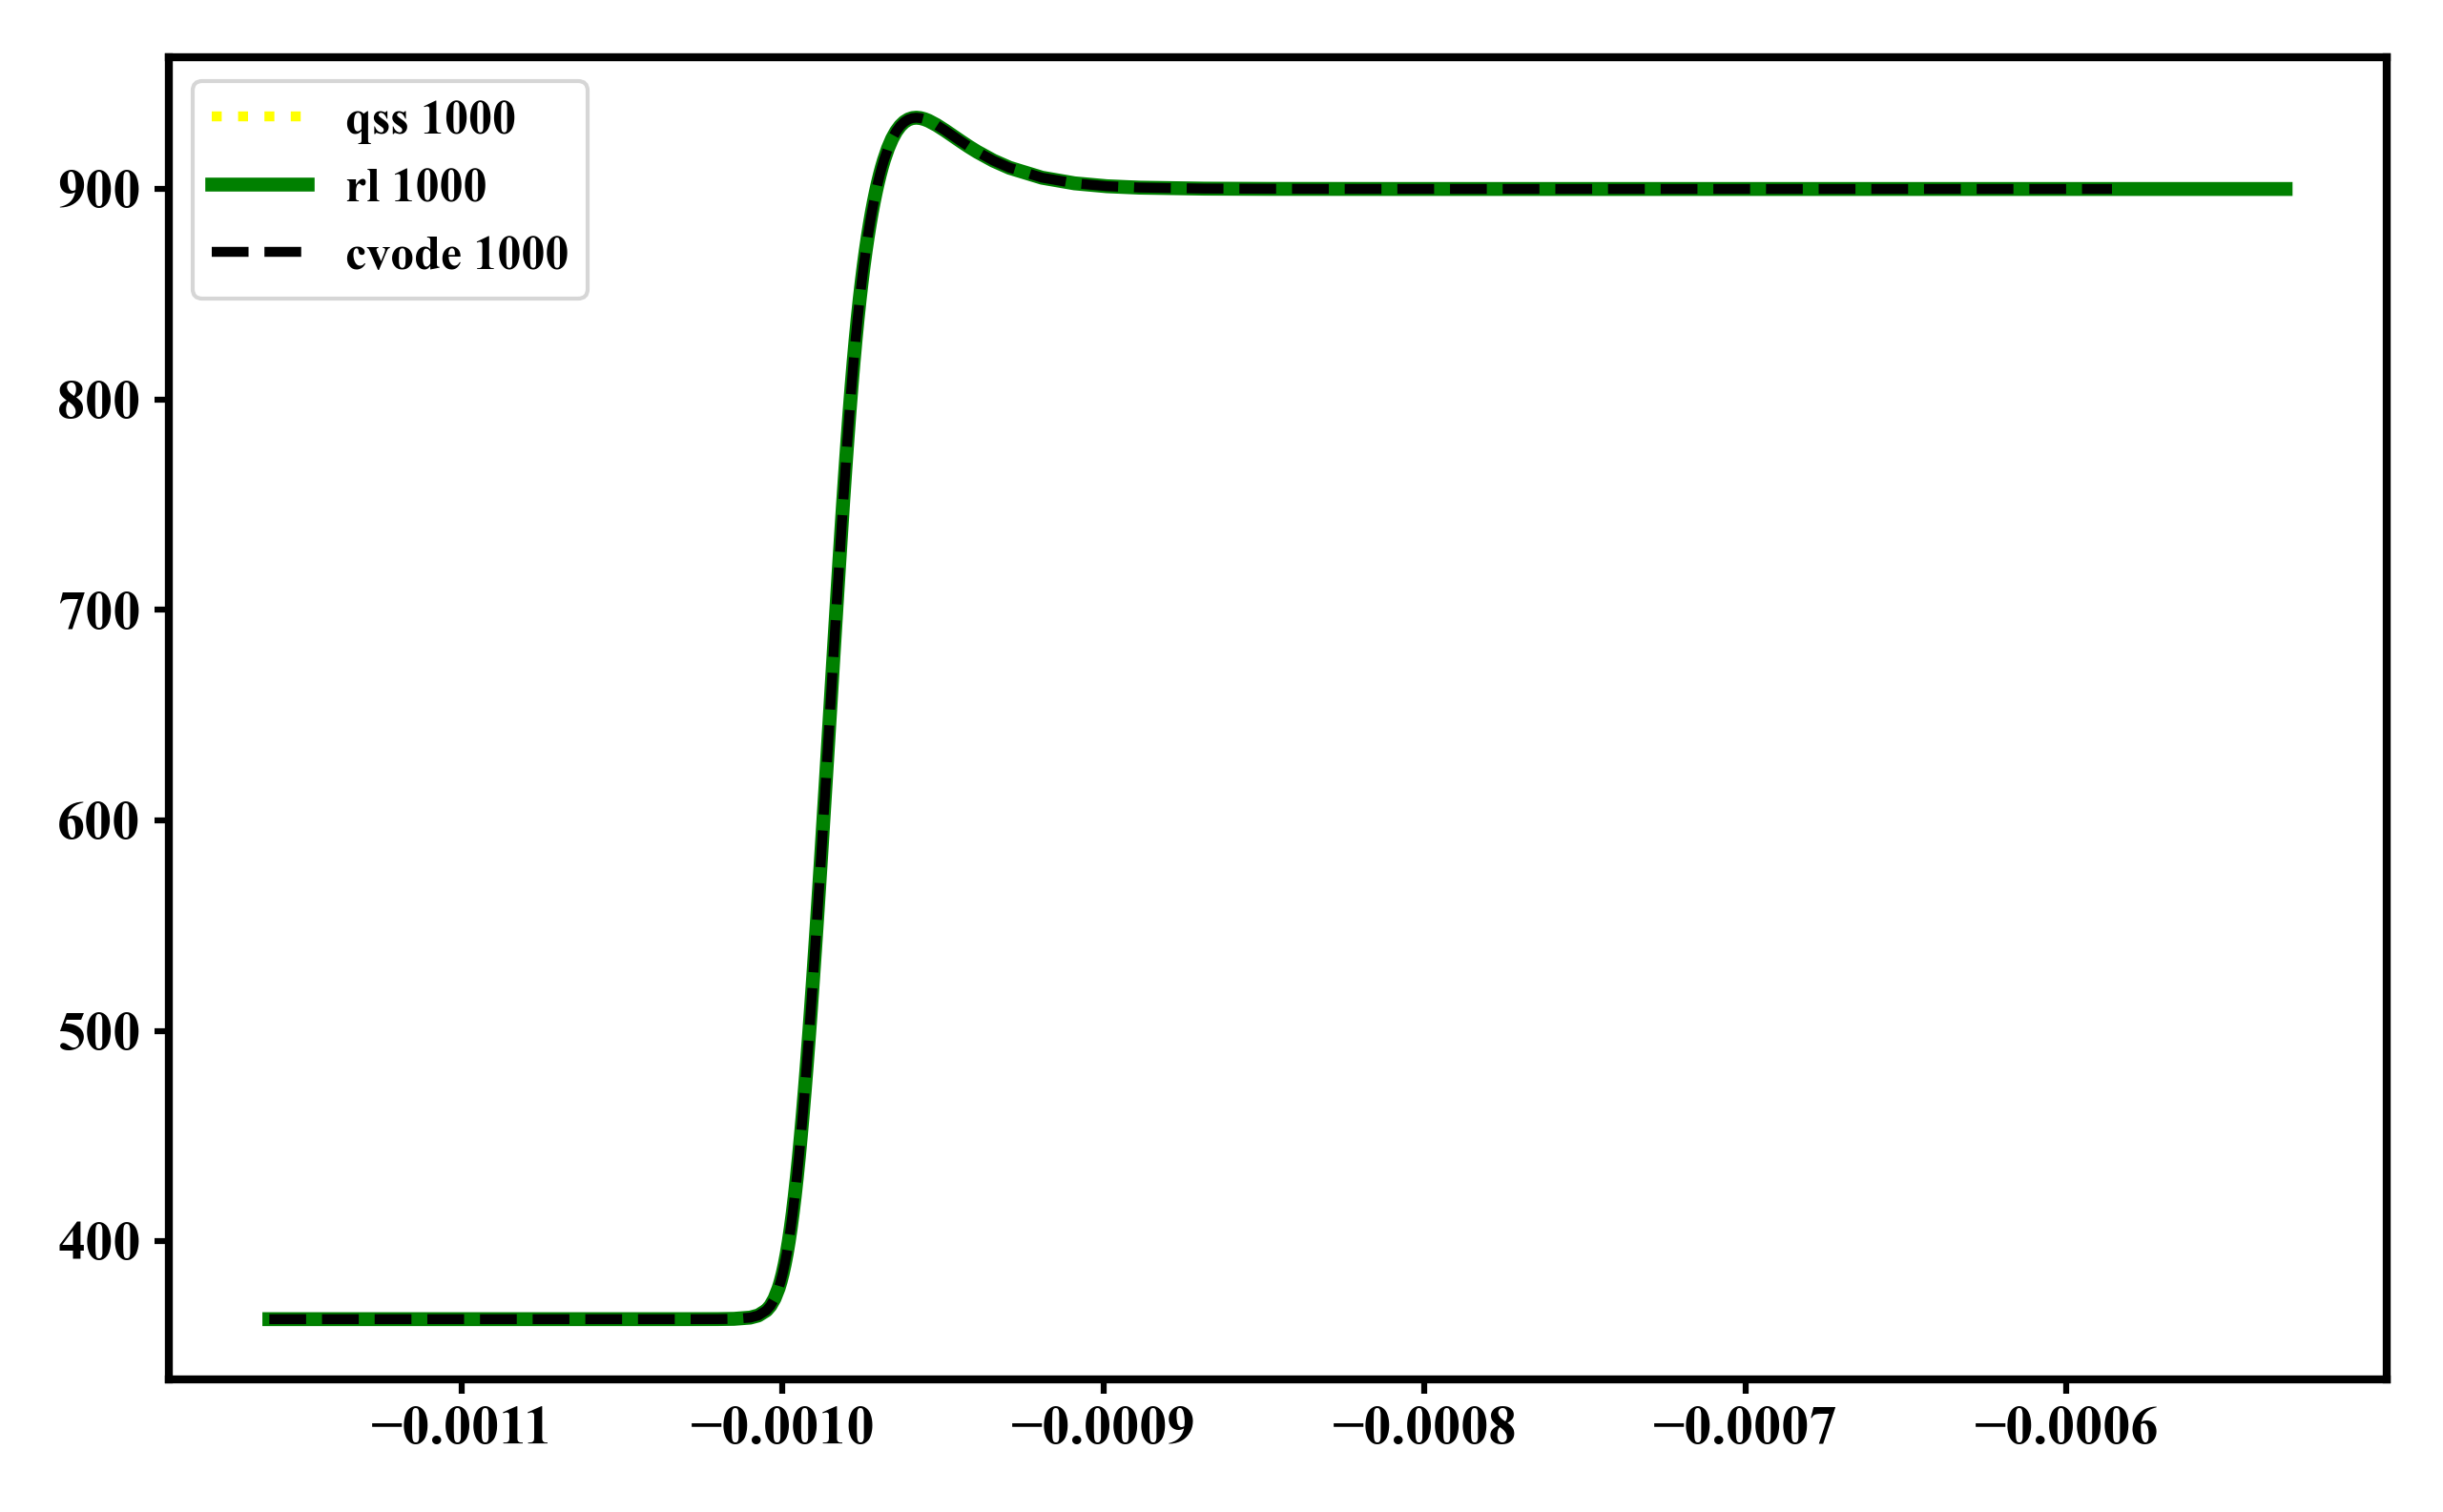

In [140]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'maroon', 'gold', 'silver', 'indigo', 'turquoise', 'coral', 'khaki', 'plum', 'salmon', 'tan', 'khaki', 'lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow', 'lightgray', 'lightpink']
# for i, time_idx in enumerate(time_indices):
i = 3
time_idx = time_indices[-1]
species_idx = species_indices[0]
T_qss = np.array(T_history_qss[time_idx])
T_rl = np.array(T_history_rl[time_idx])
T_cvode = np.array(T_history_cvode[time_idx])
X_qss = np.array(X_history_qss[time_idx])
X_rl = np.array(X_history_rl[time_idx])
rl_action = np.array(rl_action_selection[time_idx])
# actions are either cvode or qss 
rl_action = np.where(rl_action == 'cvode', 0, 1)
X_cvode = np.array(X_history_cvode[time_idx])
profile_qss = np.array(Y_history_qss[time_idx])[species_indices[species_idx], :]
profile_rl = np.array(Y_history_rl[time_idx])[species_indices[species_idx], :]
profile_cvode = np.array(Y_history_cvode[time_idx])[species_indices[species_idx], :]
plt.plot(X_qss, T_qss, label=f'qss {time_idx}', linewidth=2.5, linestyle=':', color=colors[i])
plt.plot(X_rl, T_rl, label=f'rl {time_idx}', linewidth=3.5, linestyle='-', color=colors[i-1])

plt.plot(X_cvode, T_cvode, label=f'cvode {time_idx}', linewidth=2.5, linestyle='--', color='black')
plt.legend()
plt.show()

In [122]:
print(len(rl_action), len(X_rl), len(T_rl))

105 105 105


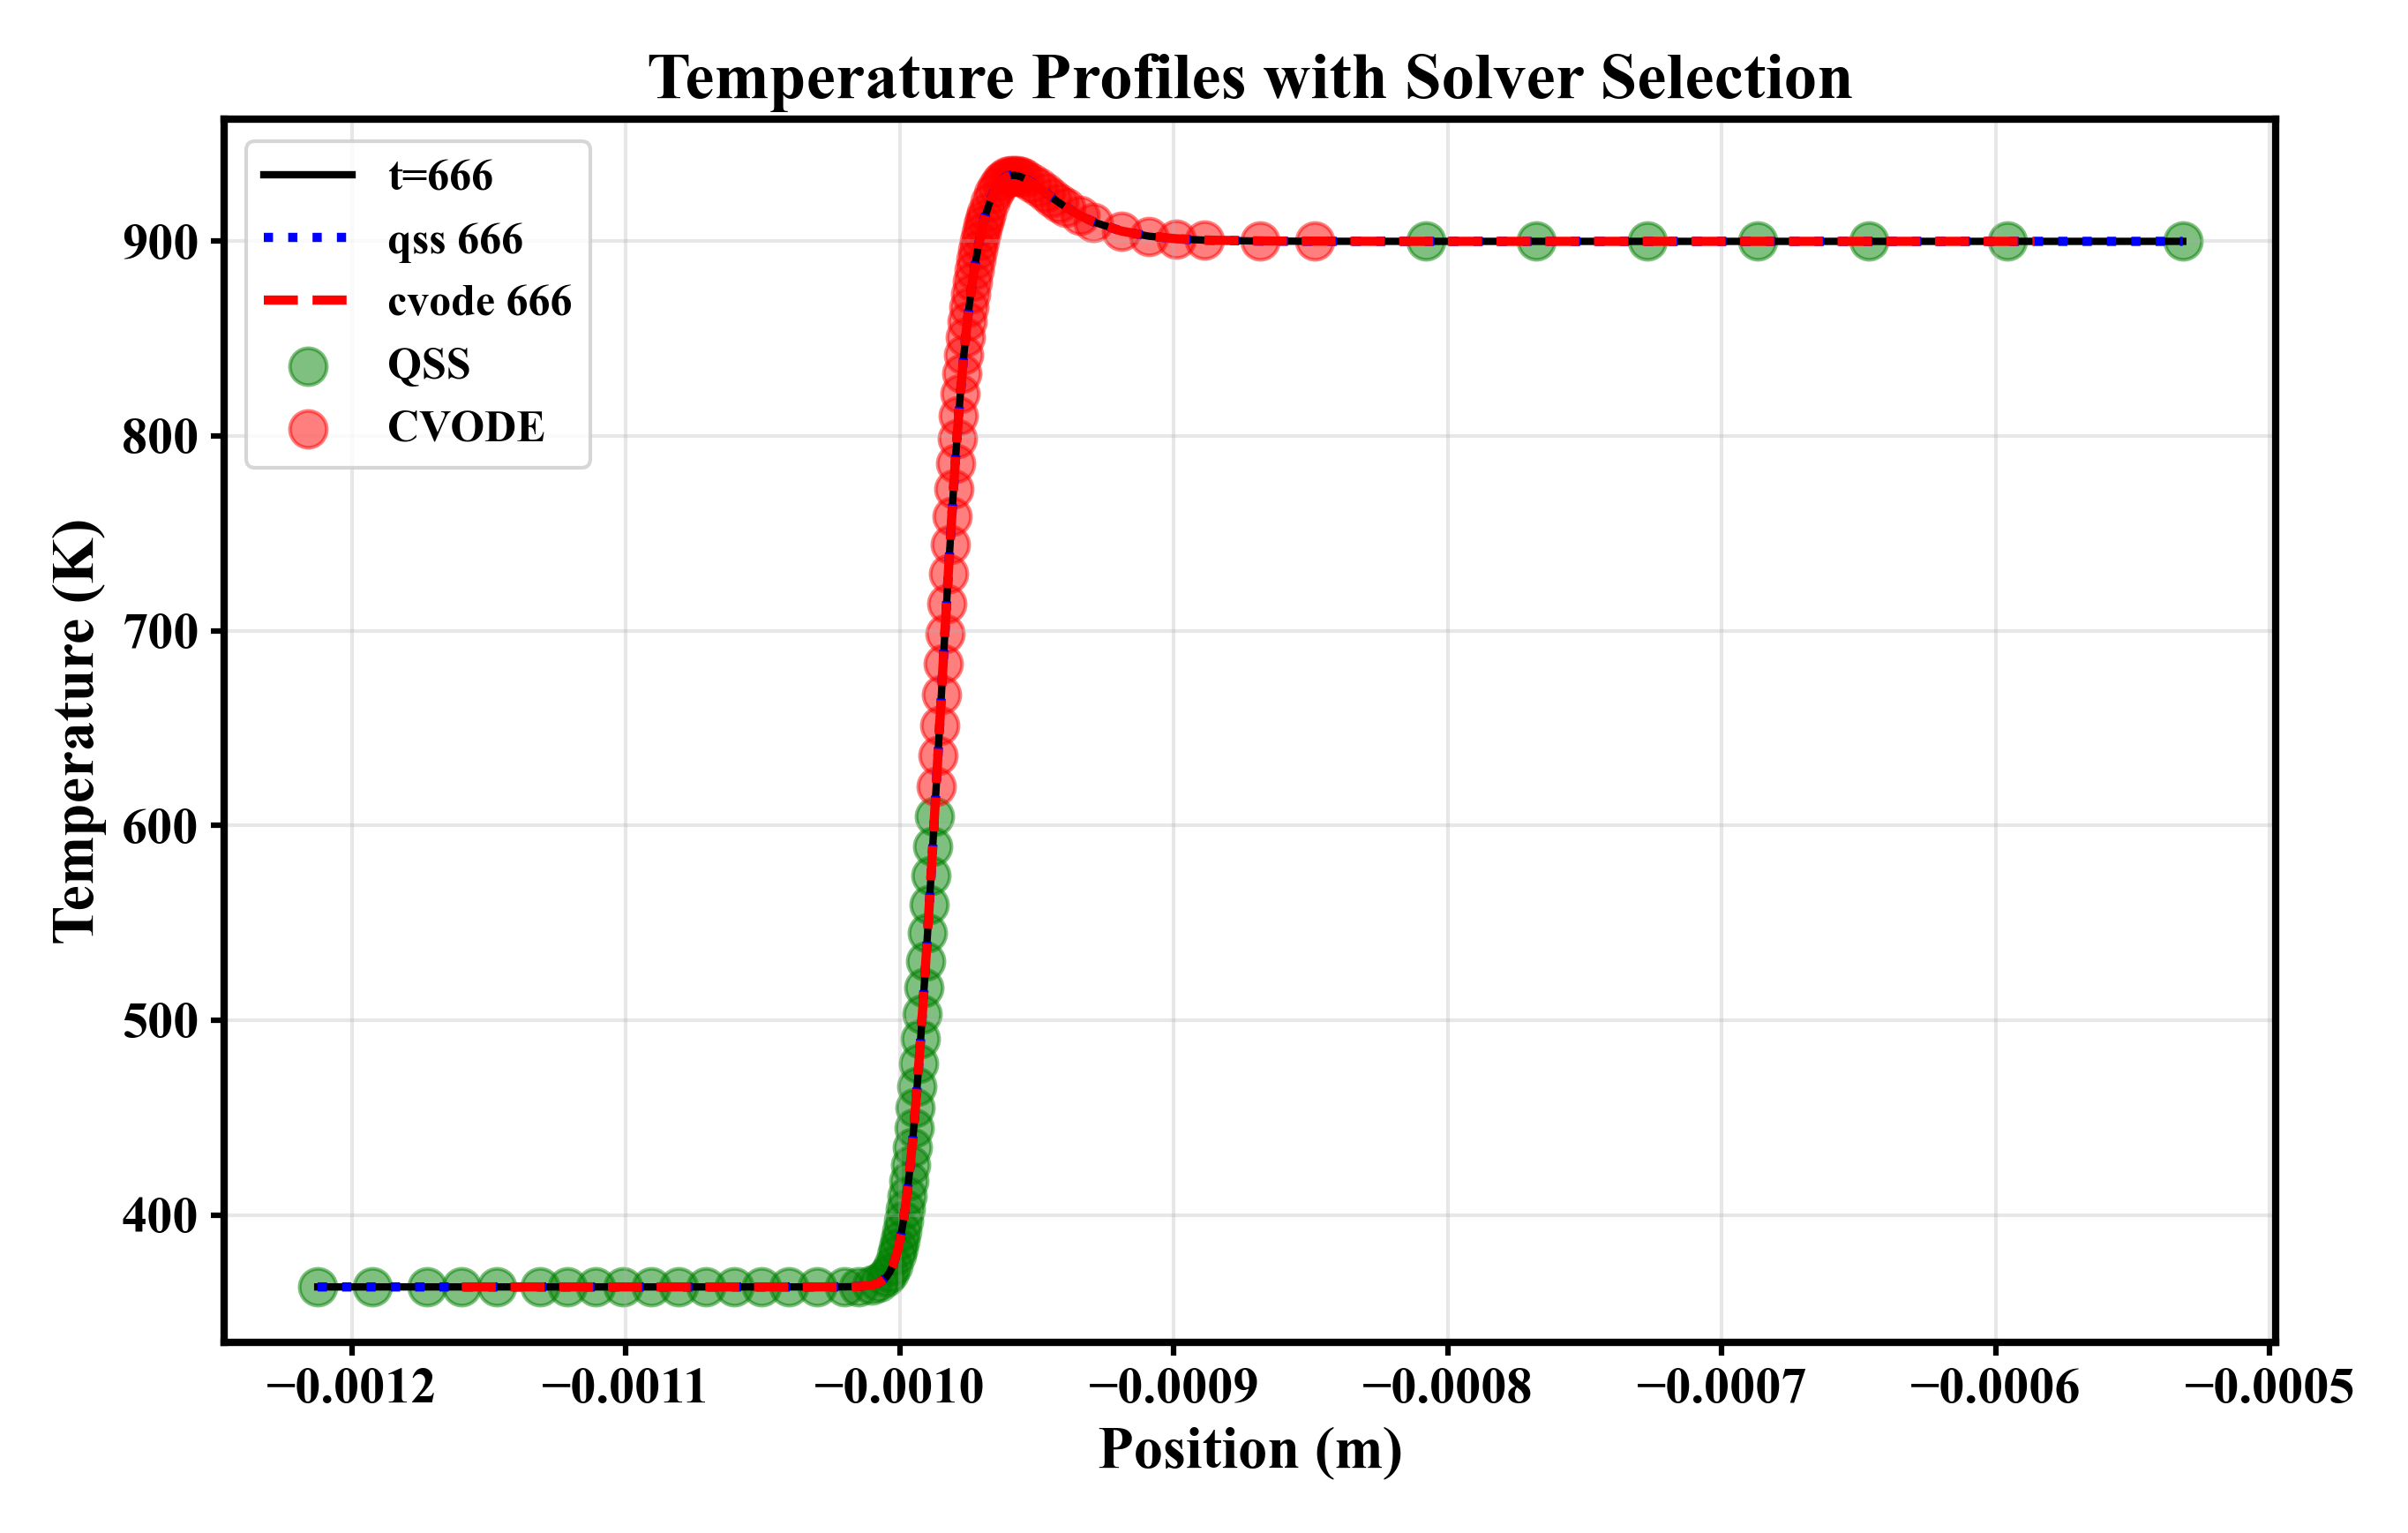

In [148]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'maroon', 'gold', 'silver', 'indigo', 'turquoise', 'coral', 'khaki', 'plum', 'salmon', 'tan', 'khaki', 'lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow', 'lightgray', 'lightpink']

i = 0
time_idx = time_indices[2]
# Get data for this timestep
T_rl = np.array(T_history_rl[time_idx])
X_rl = np.array(X_history_rl[time_idx])
T_qss = np.array(T_history_qss[time_idx])
T_cvode = np.array(T_history_cvode[time_idx])
X_qss = np.array(X_history_qss[time_idx])
X_cvode = np.array(X_history_cvode[time_idx])
rl_action = np.array(rl_action_selection[time_idx])

# Plot the full temperature profile
plt.plot(X_rl, T_rl, label=f't={time_idx}', linewidth=2, color='black')
plt.plot(X_qss, T_qss, label=f'qss {time_idx}', linewidth=2.5, linestyle=':', color='blue')
plt.plot(X_cvode, T_cvode, label=f'cvode {time_idx}', linewidth=2.5, linestyle='--', color='red')

# Add markers for QSS and CVODE points
qss_mask = (rl_action == 'qss')
cvode_mask = (rl_action == 'cvode')

plt.scatter(X_rl[qss_mask], T_rl[qss_mask], marker='o', color='green', 
            label='QSS' if i==0 else "", alpha=0.5)
plt.scatter(X_rl[cvode_mask], T_rl[cvode_mask], marker='o', color='red',
            label='CVODE' if i==0 else "", alpha=0.5)

plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Profiles with Solver Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()